### Tract tracing

In this exercise we will work with macaque tract tracing data that have been generously shared by [Henry Kennedy's lab](http://core-nets.org/).  See [Markov et al. 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3862262/) for more details about the dataset that we will use.

First need to register at the web site and then log in and download these files:

- [atlas data](http://core-nets.org/download/91%20areas%20atlas%20fitted%20on%20M132%20MRI.zip)
- [tracing data from Markov et al., 2012](http://core-nets.org/download/Cercor_2012%20Table.xls)

Create a subdirectory within the current directory called ```core-nets``` and place all of the resulting files in that directory.  This directory must contain the following files:


- 91 Areas Label.txt
- M132_7t.hdr
- M132_7t.img
- Cercor_2012 Table.xls
- Coronal Parcellation.mha


Once you have worked your way through this notebook, see the Week 5 Problem Set for more exercises with this dataset.

In [1]:
import os
import numpy,pandas
import networkx as nx
import matplotlib.pyplot as plt
import nibabel 
import nilearn.plotting
import skimage.io

%matplotlib inline

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the tracing data
tracing_data = pandas.read_excel('core-nets/Cercor_2012 Table.xls')


This dataset includes data from a number of different monkeys, which we want to combine into a single dataset.  In particular we want to focus on the variable ```FLNe``` (extrinsic fraction of labeled neurons), which reflects the proportion of labeled neurons in an area compared to the total number of labeled neurons across the brain.  

Let's first generate a dictionary of connectivity values across all of the source/target pairs.  Note that this study used a retrograde tracer, so the 29 injection sites are the target regions and 91 cortical areas are the source regions.

In [3]:
tract_dict={}
source_regions=[]
target_regions=[]
for i in tracing_data.index:
    stpair=(str(tracing_data.loc[i]['SOURCE']),str(tracing_data.loc[i]['TARGET']))
    source_regions.append(stpair[0])
    target_regions.append(stpair[1])
    if not stpair in tract_dict:
        tract_dict[stpair]=[tracing_data.loc[i]['FLNe']]
    else:
        tract_dict[stpair].append(tracing_data.loc[i]['FLNe'])

source_regions=list(set(source_regions))
target_regions=list(set(target_regions))

# confirm that we have the correct numbers of regions
assert len(source_regions)==91
assert len(target_regions)==29

# make sure that all of the target regions are present in the source regions list
assert len(set(source_regions).intersection(set(target_regions))) == len(target_regions)

Now let's summarize the FLNe values for each pair and create a directed adjacency matrix

In [4]:
adjacency_mtx = pandas.DataFrame(numpy.zeros((len(source_regions),len(source_regions))),
                                index=source_regions,columns=source_regions)
for r in adjacency_mtx.index:
    for c in adjacency_mtx.columns:
        if (r,c) in tract_dict:
            adjacency_mtx.loc[r][c] = numpy.mean(tract_dict[(r,c)])
            


Using these data, let's create a Networkx directed graph

In [5]:
G = nx.DiGraph()
FLNe_threshold=10e-4

for r in adjacency_mtx.index:
    for c in adjacency_mtx.columns:
        if adjacency_mtx.loc[r][c]>FLNe_threshold:
            G.add_edge(r, c, weight=adjacency_mtx.loc[r][c] )


In [6]:
layout = nx.spring_layout(G)
weights=nx.get_edge_attributes(G,'weight')

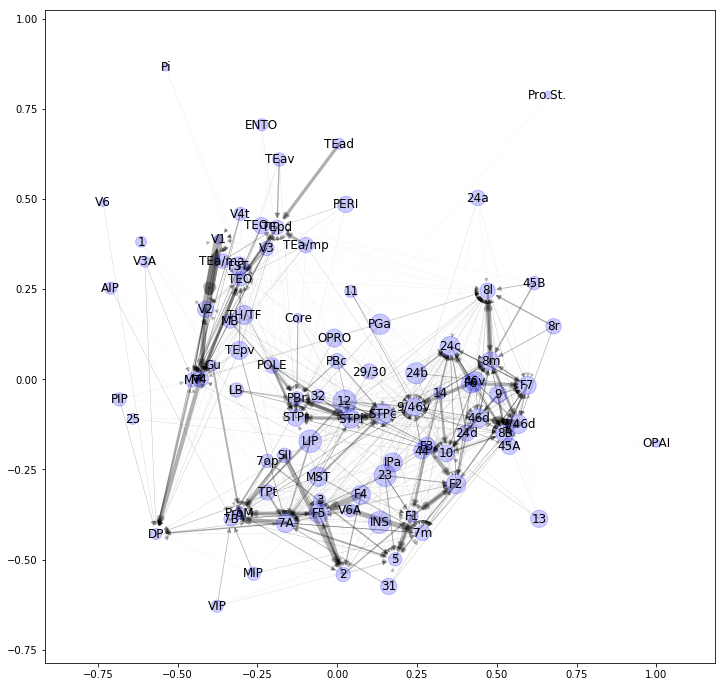

In [7]:
plt.figure(figsize=(12,12))
edge_expansion=12
node_expansion=30
_=nx.draw_networkx_edges(G,pos=layout,
                      width=[weights[i]*edge_expansion for i in G.edges],alpha=0.3)
_=nx.draw_networkx_nodes(G,pos=layout,
                         node_color='blue',
                         alpha=0.2,
                        node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=layout)


### Displaying the connectome

Now let's generate the data structures necessary to visualize the data in an anatomical format.  To do this, we need to get the anatomical coordinates for each of the regions.

The atlas data are stored in a slightly different way than the anatomical data, and both are stored in nonstandard coordinates compared to the MNI standard, so we need to reconcile them by rearranging the data before we work with them.


In [8]:
# load the anatomical image data
anatimg=nibabel.load('core-nets/M132_7t.img')
anatdata=anatimg.get_data()[:,:,:,0]

# load the atlas data
atlasdata = skimage.io.imread('core-nets/Coronal Parcellation.mha',plugin='simpleitk')


# load the atlas region info file
atlasinfo=pandas.read_csv('core-nets/91 Areas Label.txt',comment='#',
                          delim_whitespace=True,header=None,index_col=0,
                          names=['idx','r','g','b','t','v','mv','label'])

# fix problems with atlas info labeling, which is mismatched from the spreadsheet
replacement_labels={'8I':'8l',
                    "STPI":"STPi"}

for i in atlasinfo.index:
    atlasinfo.loc[i,'label']=atlasinfo.loc[i,'label'].replace('-','/')
    if atlasinfo.loc[i,'label'] in list(replacement_labels.keys()):
        atlasinfo.loc[i,'label']=replacement_labels[atlasinfo.loc[i,'label']]



In [9]:
# fix the anatomical data by rotating until they match the MNI space
anatdata_rot=numpy.rot90(anatdata,axes=(1,2))
anatdata_rot=numpy.rot90(anatdata_rot,axes=(0,2))
anatdata_rot=numpy.flip(anatdata_rot,1)

affine_fixed=numpy.identity(4)
scaling=3  # set scaling to 3 to get the coords roughly into MNI space
affine_fixed[numpy.diag_indices_from(affine_fixed)]=[0.2*scaling,0.4*scaling,0.2*scaling,1]
affine_fixed[:3,3]= numpy.array([-35,-35,-22])*scaling
anatimg_fixed=nibabel.Nifti1Image(anatdata_rot,affine=affine_fixed)
anatimg_fixed.to_filename('anatimg_fixed.nii.gz')

# fix the atlas data
atlasdata_rot=numpy.rot90(atlasdata,axes=(0,1))
atlasimg_fixed=nibabel.Nifti1Image(atlasdata_rot,affine=affine_fixed)
atlasimg_fixed.to_filename('atlasimg_fixed.nii.gz')



You can see that this worked by overlaying the atlas data on top of the anatomical data in a plot - the overlay should match perfectly.

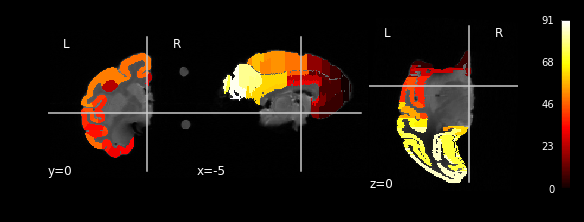

In [10]:
nilearn.plotting.plot_stat_map(atlasimg_fixed,bg_img=anatimg_fixed,cut_coords=[-5,0,0])

Now let's loop through and get the centroid location for each of the atlas regions. Then we generate the coordinates for each 2-d cut, dropping out one of the dimensions.

In [11]:
midpoint_M132={}
pos={'coronal':{},'saggital':{},'axial':{}}

for i in numpy.unique(atlasdata_rot):
    if i>0:  # skip zero-valued voxels
        matchvox=numpy.where(atlasdata_rot==i)
        # this is a kludgey way of getting the most representative voxel, but it should work
        midpoint_vox=numpy.array([numpy.median(matchvox[x]) for x in range(3)])
        # transform from voxel space to stereotactic space by applying affine from anatomical image
        mp=nibabel.affines.apply_affine(anatimg_fixed.affine,midpoint_vox)
        midpoint_M132[i]=mp 
        pos['axial'][atlasinfo.label[int(i)]]=[mp[0],mp[1]]
        pos['coronal'][atlasinfo.label[int(i)]]=[mp[0],mp[2]]
        pos['saggital'][atlasinfo.label[int(i)]]=[mp[1],mp[2]]
        


Now we can plot the full connectome in anatomical space, by converting the anatomical coordinates into a dictionary for NetworkX.  

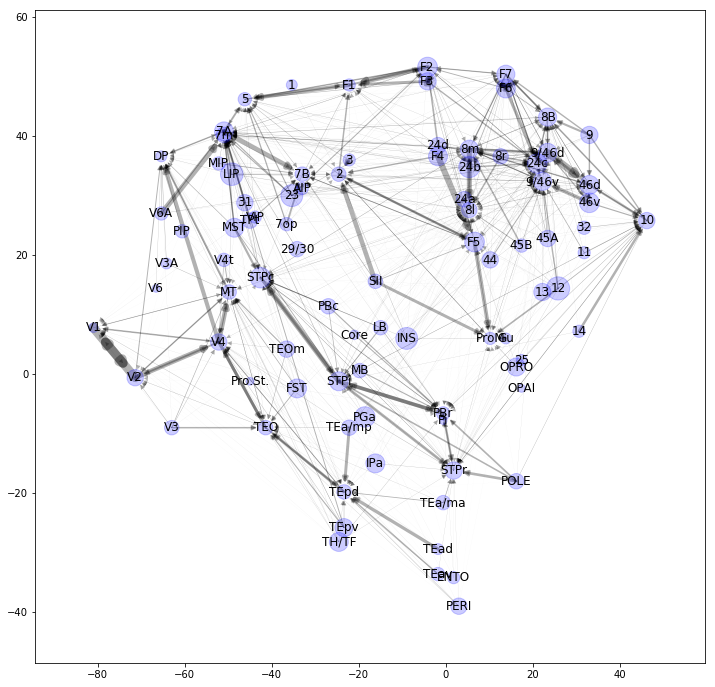

In [12]:
plt.figure(figsize=(12,12))
cut='saggital'
edge_expansion=12
node_expansion=30
_=nx.draw_networkx_edges(G,pos=pos[cut],
                      width=[weights[i]*edge_expansion for i in G.edges],alpha=0.3)
_=nx.draw_networkx_nodes(G,pos=pos[cut],
                         node_color='blue',
                         alpha=0.2,
                        node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=pos[cut])

